In [1]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from IPython.display import HTML
import great_tables as gt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [2]:
"""ArmStrength.ipynb
Get all throwing information
    - Attribute each throw to player_id/position
    - Max. velocity of each throw
      (Drag-adjusted)
      (Don't use cubic interpolation because collisions like bounce)
    - Transition time
    - Release position
Get E[95th_velo|player,transition_time]


1. Get every ball acquired-throw event (& transition time)
    Using game_events, ball_pos
2. Attribute each throw to player_id/position
    Using game_info, player_pos
3. Attribute all ball positions to throws
    With occlusion adjustment
4. Estimate velocities across each throw
5. Use drag model to estimate velocity at ball release 
    (i.e. max. ball velocity in a throw)
6. Histogram & Leaderboards
"""
pass

In [3]:
"""
Get every ball acquired-throw event (& transition time)
    Using game_events, ball_pos
    1. Get every event
    2. Get transition times
    3. Get end timestamp
    4. Filter for throws (separate out transition times)
    5. Get every ball_acquired event
    6. Concatenate
"""
## 1. Get every event
every_throw = game_events_subset.to_table(columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']).to_pandas()
every_throw = every_throw.sort_values(by=["game_str","play_id","timestamp"])

## 2. Get transition times
every_throw['acq_ts'] = every_throw.groupby(['game_str','play_id'])['timestamp'].shift(1).astype('Int64')
every_throw['trans_ms'] = every_throw['timestamp'] - every_throw['acq_ts']

## 3. Get end timestamp (this is timestamp for next event)
# (end_ts isn't necessarily catch_time, but this is irrelevant for release_velocity)
# next event_code timestamp with the same play_id
every_throw['end_ts'] = every_throw.groupby(['game_str','play_id'])['timestamp'].shift(-1).astype('Int64')
# Rename
every_throw = every_throw.rename(columns={"timestamp":"start_ts"})

## 4. Filter for throws
every_throw = every_throw[(every_throw['event_code'] == 3)]  # Not including unknown field positions
# We will merge transition_times later (estimating max. velocity)
transition_times = every_throw[['game_str','play_id','player_position','trans_ms']]

## 5. Get every ball_acquired event
# (This becomes useful later on for adjusting ball position)
every_acq = game_events_subset.to_table(columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']).to_pandas()
every_acq = every_acq.sort_values(by=["game_str","play_id","timestamp"])
# (It should have a different logic for acq_ts, start_ts, end_ts)
every_acq = every_acq.rename(columns={"timestamp":"acq_ts"})
every_acq['start_ts'] = every_acq.groupby(['game_str','play_id'])['acq_ts'].shift(-1).astype('Int64')
every_acq['trans_ms'] = every_acq['start_ts'] - every_acq['acq_ts']
every_acq['end_ts'] = every_acq.groupby(['game_str','play_id'])['acq_ts'].shift(-2).astype('Int64')
every_acq = every_acq[(every_acq['event_code'] == 2)]

## 6. Concatenate
every_throw = pd.concat([every_throw, every_acq])
every_throw = every_throw.sort_values(by=["game_str","play_id","start_ts"]) # Keep it sorted

print("Number of acquired:", len(every_throw[every_throw['event_code']==2]))
print("Number of throws:", len(every_throw[every_throw['event_code']==3]))
every_throw.iloc[5:15].T

Number of acquired: 76023
Number of throws: 10331


,8941,8940,8942,8945,8948,8951,8954,8957,8960,8963
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,4,4,4,5,6,7,8,9,10,11
play_per_game,4,4,4,5,6,7,8,9,10,11
start_ts,88399,88399,89699,122899,148849,171399,196549,218049,257149,276749
player_position,7,7,6,2,2,2,2,2,2,2
event_code,3,2,2,2,2,2,2,2,2,2
acq_ts,86799,86799,89699,122899,148849,171399,196549,218049,257149,276749
trans_ms,1600,1600,0,0,0,0,0,0,0,0
end_ts,89699,89699,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [4]:
"""
Attribute each throw to player_id/position
    Using game_info, player_pos
"""
game_info = game_info_subset.to_table().to_pandas()
every_throw_info = pd.merge(every_throw, game_info, how="inner", on = ['game_str','play_per_game'])
conditions = [
    every_throw_info['player_position'] == 1,    every_throw_info['player_position'] == 2,
    every_throw_info['player_position'] == 3,    every_throw_info['player_position'] == 4,
    every_throw_info['player_position'] == 5,    every_throw_info['player_position'] == 6,
    every_throw_info['player_position'] == 7,    every_throw_info['player_position'] == 8,
    every_throw_info['player_position'] == 9,    every_throw_info['player_position'] == 10,
    every_throw_info['player_position'] == 11,    every_throw_info['player_position'] == 12,
    every_throw_info['player_position'] == 13,    every_throw_info['player_position'] == 14,
    every_throw_info['player_position'] == 15,    every_throw_info['player_position'] == 16,
    every_throw_info['player_position'] == 17,    every_throw_info['player_position'] == 18,
    every_throw_info['player_position'] == 19,    every_throw_info['player_position'] == 255
]
choices = [
    every_throw_info['pitcher'],    every_throw_info['catcher'],
    every_throw_info['first_base'],    every_throw_info['second_base'],
    every_throw_info['third_base'],    every_throw_info['shortstop'],
    every_throw_info['left_field'],    every_throw_info['center_field'],
    every_throw_info['right_field'],    every_throw_info['batter'],
    every_throw_info['first_baserunner'],    every_throw_info['second_baserunner'],
    every_throw_info['third_baserunner'],    "Umpire",
    "Umpire",    "Umpire",
    "Umpire",    "Coach",
    "Coach",    "Ball-event-with-no-player"
]
# throw_id is player_id of the thrower
every_throw_info['thrower_id'] = np.select(conditions, choices, default=None)
# Rid unused columns
every_throw_info = every_throw_info.drop(columns=['pitcher','catcher','first_base','second_base','third_base','shortstop','left_field','center_field','right_field','batter','first_baserunner','second_baserunner','third_baserunner','year','day','home_team','away_team','top_bottom_inning','at_bat'])

print("Number of acquired (updated):", len(every_throw_info[every_throw_info['event_code']==2]))
print("Number of throws (updated):", len(every_throw_info[every_throw_info['event_code']==3]))
every_throw_info.head(2)

Number of acquired (updated): 69108
Number of throws (updated): 9298


,game_str,play_id,play_per_game,start_ts,player_position,event_code,acq_ts,trans_ms,end_ts,thrower_id
0,y1_d001_CGA_QEA,1,1,9199,2,2,9199,0,<NA>,QEA-0071
1,y1_d001_CGA_QEA,2,2,31649,9,3,29299,2350,32799,QEA-0252


Number of throws:  9421

Mean ms between acquisition & throw:  1675
Mean ms between throw & end:  1771

Expected # timestamps between acquisition & throw (50ms interval):  315660
Expected # timestamps between throw & end (50ms interval):  333796

Actual # timestamps between acquisition & throw:  61393
Actual # timestamps between throw & end:  367805


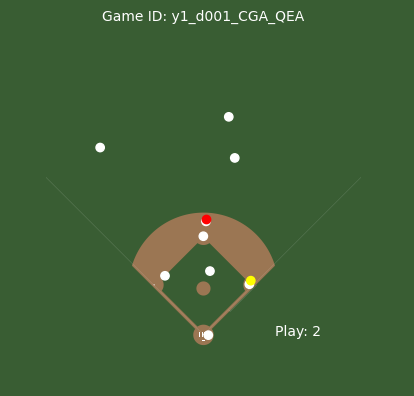

In [5]:
"""
Attribute all ball positions to throws
    With occlusion adjustment
    1. Attribute all ball_pos to throws
    2. (Deprecated: Get player position)
    3. Occlusion analysis: Camera can't track ball when it's in the player's hand
    4. Fill empty rows where no ball tracking
    5. Apply occlusion adjustment
        Use latest ball position 
        Calculate distance from center of mass
        Then scale the distance to be max. 3ft from body (player_pos)
"""
## 1. Attribute all ball_pos to throws
ball_pos = ball_position_subset.to_table(columns = ['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']).to_pandas()
every_throw_tracking = pd.merge(every_throw_info, ball_pos, how="left", on=["game_str","play_id"])
every_throw_tracking['timestamp'] = every_throw_tracking['timestamp'].astype('Int64')
# Filter for throws
every_throw_tracking = every_throw_tracking[(every_throw_tracking['timestamp'] >= every_throw_tracking['acq_ts']) & 
                                          (every_throw_tracking['timestamp'] <= every_throw_tracking['end_ts'])]

## 2. (Deprecated: Get player position)
player_pos = player_position_subset.to_table(columns = ["game_str","play_id","timestamp","player_position","field_x","field_y"]).to_pandas()
# Recall that every_throw has the list of all throws
# Filter player_pos by game_str, play_id, player_position from every_throw
every_throw_list = every_throw[['game_str','play_id','player_position','acq_ts','end_ts']]
every_throw_pos = pd.merge(every_throw_list, player_pos, how="left", on=['game_str','play_id','player_position'])
# Only timestamps between ball acquisition & ball throw
every_throw_pos = every_throw_pos[(every_throw_pos['timestamp'] >= every_throw_pos['acq_ts']) &(every_throw_pos['timestamp'] <= every_throw_pos['end_ts'])]
every_throw_pos = every_throw_pos.drop_duplicates(subset=["game_str","play_id","player_position","acq_ts","end_ts","timestamp"], keep='first').reset_index(drop=True) 

## 3. Occlusion analysis: Camera can't track ball when it's in the player's hand
# Ball acquisition & Ball throw timestamps
acq_thr = game_events_subset.to_table(columns = ['game_str','play_id','timestamp','event_code']).to_pandas()
acq = acq_thr[acq_thr['event_code']==2]
acq = acq.rename(columns={"timestamp":"acq_ts"}).drop(columns='event_code')
thr = acq_thr[acq_thr['event_code']==3]
thr = thr.rename(columns={"timestamp":"thr_time"}).drop(columns='event_code')
# Timestamp for when thrown ball becomes caught/bounced/etc. (next event_code)
end = acq_thr[acq_thr['event_code'].shift(1)==3]
end = end.rename(columns={"timestamp":"end_ts"}).drop(columns='event_code')
# Ball position timestamps
ball = ball_position_subset.to_table().to_pandas()
ball = pd.merge(ball, acq, how="left", on=['game_str','play_id'])
ball = pd.merge(ball, thr, how="left", on=['game_str','play_id'])
ball = pd.merge(ball, end, how="left", on=['game_str','play_id'])
# Filter by timestamps between acq & end
ball = ball[(ball['timestamp'] >= ball['acq_ts']) & (ball['timestamp'] <= ball['end_ts'])]
# Counts
print("Number of throws: ", len(acq_thr[acq_thr['event_code']==3].groupby(['game_str','play_id','event_code'])))
print("\nMean ms between acquisition & throw: ", int((ball['thr_time']-ball['acq_ts']).mean()))
print("Mean ms between throw & end: ", int((ball['end_ts']-ball['thr_time']).mean()))
print("\nExpected # timestamps between acquisition & throw (50ms interval): ", int((ball['thr_time']-ball['acq_ts']).mean()/50*9421))
print("Expected # timestamps between throw & end (50ms interval): ", int((ball['end_ts']-ball['thr_time']).mean()/50*9421))
print("\nActual # timestamps between acquisition & throw: ", len(ball[(ball['timestamp'] > ball['acq_ts']) & (ball['timestamp'] < ball['thr_time'])]))
print("Actual # timestamps between throw & end: ", len(ball[(ball['timestamp'] > ball['thr_time']) & (ball['timestamp'] < ball['end_ts'])]))
# Visualize an example
from Animation import plot_animation
player_position_df = player_position_subset.to_table().to_pandas()
player = player_position_df[(player_position_df['game_str'] == "y1_d001_CGA_QEA")&(player_position_df['timestamp']>28000)]
ball = ball_pos[(ball_pos['game_str'] == "y1_d001_CGA_QEA")&(ball_pos['timestamp']>28000)]
# Moved to bottom
# plot_animation(player, ball, play_id=2, save_gif=False)

## 4. Fill empty rows where no ball tracking
# print("len(every_throw_pos): ", len(every_throw_pos))
# print("len(every_throw_tracking): ", len(every_throw_tracking))
# Fill all rows with play_per_game/start_ts/event_code/trans_ms where NA
temp_df = every_throw_tracking.drop(columns=['ball_position_x','ball_position_y','ball_position_z','timestamp'])
temp_df = temp_df.drop_duplicates()
every_throw_withpos = pd.merge(every_throw_pos, temp_df, 
                               how="left", on=["game_str","play_id","player_position","acq_ts","end_ts"])
# print("(After fill) len(every_throw_withpos): ", len(every_throw_withpos))
# Join all ball_pos with player position
every_throw_withpos = pd.merge(every_throw_withpos, every_throw_tracking, how="left",
                               on=["game_str","play_id","player_position","play_per_game","thrower_id","trans_ms","event_code","acq_ts","start_ts","end_ts","timestamp"])
# print("(Fillx2) len(every_throw_withpos): ", len(every_throw_withpos))
# Drop duplicates (wrong event_codes)
drop_mask = (
    ((every_throw_withpos['timestamp'] >= every_throw_withpos['start_ts']) & (every_throw_withpos['event_code'] == 2)) |
    ((every_throw_withpos['timestamp'] <  every_throw_withpos['start_ts']) & (every_throw_withpos['event_code'] == 3)))
every_throw_withpos = every_throw_withpos[~drop_mask]
# print("(After dropping) len(every_throw_withpos): ", len(every_throw_withpos))

## 5. Apply occlusion adjustment
# Use latest ball position 
# Calculate distance from center of mass
# Then scale the distance to be max. 3ft from body (player_pos)
every_throw_withpos["latest_ball_pos_x"] = every_throw_withpos.groupby("acq_ts")["ball_position_x"].ffill()
every_throw_withpos["latest_ball_pos_y"] = every_throw_withpos.groupby("acq_ts")["ball_position_y"].ffill()
every_throw_withpos["latest_ball_pos_z"] = every_throw_withpos.groupby("acq_ts")["ball_position_z"].ffill()
every_throw_withpos['ball_x_frombody'] = every_throw_withpos['latest_ball_pos_x'] - every_throw_withpos['field_x']
every_throw_withpos['ball_y_frombody'] = every_throw_withpos['latest_ball_pos_y'] - every_throw_withpos['field_y']
every_throw_withpos['ball_dist_frombody'] = np.sqrt(every_throw_withpos['ball_x_frombody']**2 +
                                                     every_throw_withpos['ball_y_frombody']**2)
every_throw_withpos['ball_dist_scalefactor'] = np.minimum(3 / every_throw_withpos['ball_dist_frombody'], 1)
every_throw_withpos['ball_x_frombody_scaled'] = every_throw_withpos['ball_x_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_y_frombody_scaled'] = every_throw_withpos['ball_y_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_pos_x_adj'] = every_throw_withpos['field_x'] + every_throw_withpos['ball_x_frombody_scaled']
every_throw_withpos['ball_pos_y_adj'] = every_throw_withpos['field_y'] + every_throw_withpos['ball_y_frombody_scaled']
every_throw_withpos['ball_pos_z_adj'] = every_throw_withpos["latest_ball_pos_z"] # No change for z
# Don't scale after ball leaves body (i.e. 1 timestamp after event_code turns 3)
mask = (every_throw_withpos['event_code'] == 3) & (every_throw_withpos['event_code'].shift(1) == 3)
every_throw_withpos.loc[mask, 'ball_pos_x_adj'] = every_throw_withpos.loc[mask, 'ball_position_x']
every_throw_withpos.loc[mask, 'ball_pos_y_adj'] = every_throw_withpos.loc[mask, 'ball_position_y']

# Cleanup
every_throw_withpos = every_throw_withpos[['game_str','play_id','player_position','thrower_id','acq_ts','start_ts','end_ts','trans_ms','timestamp','event_code','ball_pos_x_adj','ball_pos_y_adj','ball_pos_z_adj']]

plot_animation(player, ball, play_id=2, save_gif=False)

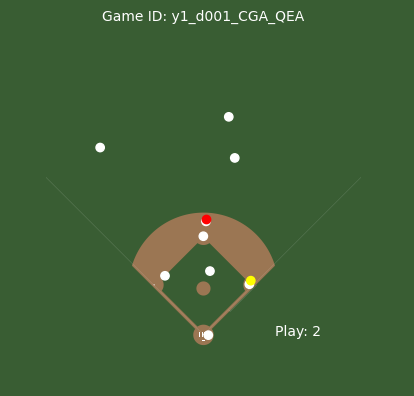

In [6]:
## Quick Visualization
game_str = "y1_d001_CGA_QEA"
play_id = 2
player_position_df = player_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()
ball_position_df = every_throw_withpos[every_throw_withpos['game_str'] == game_str]
ball_position_df = ball_position_df[['game_str','play_id','timestamp','ball_pos_x_adj','ball_pos_y_adj','ball_pos_z_adj']]
ball_position_df = ball_position_df.rename(columns={"ball_pos_x_adj":"ball_position_x",
                                                    "ball_pos_y_adj":"ball_position_y",
                                                    "ball_pos_z_adj":"ball_position_z"})
temp_df = ball_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()
keys = ['game_str', 'play_id', 'timestamp']
existing_keys = set(ball_position_df[keys].apply(tuple, axis=1))
df2_no_dupes = temp_df[~temp_df[keys].apply(tuple, axis=1).isin(existing_keys)]
result = pd.concat([ball_position_df, df2_no_dupes], ignore_index=True)
plot_animation(player_position_df, result, play_id, save_gif=False)

In [7]:
"""
Estimate velocities across each throw.
We'll do this by distance ÷ time across 1 time interval (2 timestamps)
Keep in mind we're using adjusted ball positions now
"""
# Estimate velocity at previous interval
every_throw_withpos['prev_ball_pos_x_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_x_adj"].shift(1)
every_throw_withpos['prev_ball_pos_y_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_y_adj"].shift(1)
every_throw_withpos['prev_ball_pos_z_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_z_adj"].shift(1)
every_throw_withpos['prev_timestamp'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["timestamp"].shift(1)

# Get displacements
every_throw_withpos['ball_displacement_x'] = every_throw_withpos['ball_pos_x_adj'] - every_throw_withpos['prev_ball_pos_x_adj']
every_throw_withpos['ball_displacement_y'] = every_throw_withpos['ball_pos_y_adj'] - every_throw_withpos['prev_ball_pos_y_adj']
every_throw_withpos['ball_displacement_z'] = every_throw_withpos['ball_pos_z_adj'] - every_throw_withpos['prev_ball_pos_z_adj']
every_throw_withpos['ball_rad_xy'] = np.arctan2(every_throw_withpos['ball_displacement_x'],every_throw_withpos['ball_displacement_y'])
every_throw_withpos['ball_distance'] = np.sqrt(every_throw_withpos['ball_displacement_x']**2 + 
                                           every_throw_withpos['ball_displacement_y']**2 + 
                                           every_throw_withpos['ball_displacement_z']**2)

# Timestamps are in ms; ÷1000 to get s
every_throw_withpos['prev_interval_length_ms'] = every_throw_withpos['timestamp'] - every_throw_withpos['prev_timestamp']
every_throw_withpos['prev_interval_ballspeed'] = every_throw_withpos['ball_distance'] / (every_throw_withpos['prev_interval_length_ms']/1000)  # ft/s

# Drop used columns
every_throw_withpos = every_throw_withpos.drop(
    columns=["prev_ball_pos_x_adj","prev_ball_pos_y_adj","prev_ball_pos_z_adj",
             "ball_displacement_x","ball_displacement_y","ball_displacement_z"])

every_throw_withpos.head(5).T

,1,3,5,7,9
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,2,2,2,2
player_position,9,9,9,9,9
thrower_id,QEA-0252,QEA-0252,QEA-0252,QEA-0252,QEA-0252
acq_ts,29299,29299,29299,29299,29299
start_ts,31649,31649,31649,31649,31649
end_ts,32799,32799,32799,32799,32799
trans_ms,2350,2350,2350,2350,2350
timestamp,29299.0,29349.0,29399.0,29449.0,29499.0
event_code,2.0,2.0,2.0,2.0,2.0


c:\Users\mla21\OneDrive\2nd Brain\100 Projects\SMT2025\Code\Helpers.py:26: RuntimeWarning: invalid value encountered in multiply
  disc  = 1.0 - 4.0 * A * v_avg
c:\Users\mla21\OneDrive\2nd Brain\100 Projects\SMT2025\Code\Helpers.py:31: RuntimeWarning: invalid value encountered in divide
  v0[valid] = (1.0 - np.sqrt(disc[valid])) / (2.0 * A[valid])


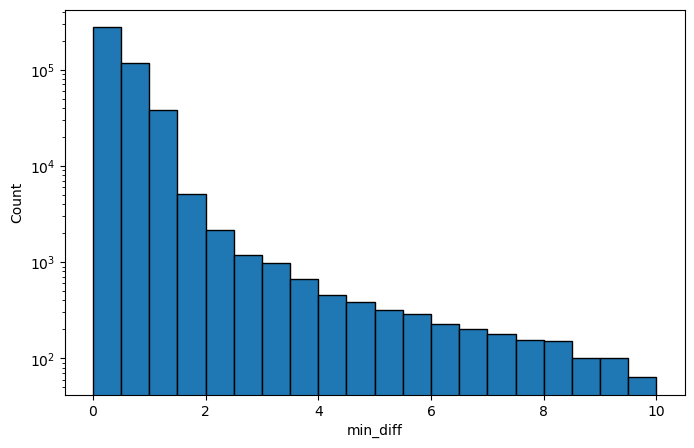

Number of deleted rows:  7155
Number of remaining rows:  438699


,game_str,play_id,throw_ts,player_position,thrower_id,trans_ms,ball_rel_x_adj,ball_rel_y_adj,ball_rel_z_adj,throw_mph
0,y1_d001_CGA_QEA,2,31649,9,QEA-0252,2350,36.012866,231.781533,5.65836,57.953321
1,y1_d001_CGA_QEA,4,88399,7,QEA-0249,1600,-116.819326,196.810441,5.07150,48.983998
2,y1_d001_CGA_QEA,17,444799,6,QEA-0027,850,-2.255579,161.877824,6.46233,74.593285
3,y1_d001_CGA_QEA,21,562499,5,QEA-0180,700,-49.116546,93.489200,3.99978,63.180153
4,y1_d001_CGA_QEA,21,563799,4,QEA-0365,650,2.950940,122.878920,4.18248,65.006188


In [8]:
"""
Use drag model to estimate velocity at ball release 
    (i.e. max. ball velocity in a throw)
"""
from Helpers import estimate_v0

every_throw_dragadj = every_throw_withpos
every_throw_dragadj['ms_since_release'] = np.maximum(every_throw_dragadj['timestamp'] - 
                                                 every_throw_dragadj['start_ts'], 0)
every_throw_dragadj['v0_dragadj'] = estimate_v0(every_throw_dragadj['prev_interval_ballspeed'],
                                            every_throw_dragadj['ms_since_release'])

## Cleanup noise
# We're gonna get rid of all rows where its prev_interval_ballspeed value is 
#   more than CUTOFF ft/s off compared to the row above & below
CUTOFF = 3.0
every_throw_withpos_clean = every_throw_withpos.copy()
every_throw_withpos_clean['speed_above'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(1)
every_throw_withpos_clean['speed_below'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(-1)
every_throw_withpos_clean['diff_above'] = abs(every_throw_withpos_clean['speed_above'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['diff_below'] = abs(every_throw_withpos_clean['speed_below'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['min_diff'] = np.minimum(every_throw_withpos_clean['diff_above'], every_throw_withpos_clean['diff_below'])

# Q. Shouldn't the ball always slow down? Why min_diff?
# A. Oh yeah, so if it's more than 2fps faster than next timestamp
#    (Since we're not considering bounces)

# According to drag calculations
# Over a 50 ms interval, a 100 mph baseball loses on the order of
# 0.5–0.9 m/s (≈ 1.5–3 fps) (≈ 1.2–2.0 mph) 

# Use a histogram to determine the ???
bins = np.arange(0, 10 + 0.5, 0.5)
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(every_throw_withpos_clean['min_diff'], bins=bins, edgecolor='black')
plt.xlabel('min_diff')
plt.ylabel('Count')
plt.yscale('log')  # log scale
plt.show()

# DECISION: 3.0 ft/s
display_df = every_throw_withpos_clean.copy()  # For display
display_df['delete'] = ((display_df['min_diff'] > CUTOFF))
deleted_rows = every_throw_withpos_clean[(display_df['min_diff'] > CUTOFF)]
# Keep row if min_diff <= 3.0 ft/s 
every_throw_withpos_clean = every_throw_withpos_clean[(display_df['min_diff'] <= CUTOFF)]
print(f"Number of deleted rows:  {len(deleted_rows)}")
print(f"Number of remaining rows:  {len(every_throw_withpos_clean)}")
display_df = display_df[["game_str","play_id","player_position","event_code",
                         "timestamp","ball_pos_x_adj","ball_pos_y_adj","ball_pos_z_adj",
                         "ball_distance","prev_interval_ballspeed","min_diff","delete"]]

## Estimate max. velocities for each throw
every_throw_clean = every_throw_withpos_clean.groupby(
    ["game_str","play_id","start_ts","player_position","thrower_id","trans_ms"]).agg(
        throw_fps = ('v0_dragadj','max')
    ).reset_index()

## Ball release point
# (It's not a mistake to use every_throw_withpos instead of every_throw_withpos_clean)
rel_points = every_throw_withpos[every_throw_withpos['timestamp']==every_throw_withpos['start_ts']]
every_throw_clean = every_throw_clean.merge(rel_points[['game_str','play_id','start_ts','ball_pos_x_adj','ball_pos_y_adj','ball_pos_z_adj']],
                                            how='left', on=['game_str','play_id','start_ts'])
every_throw_clean = every_throw_clean.rename(columns={'ball_pos_x_adj':'ball_rel_x_adj', 'ball_pos_y_adj':'ball_rel_y_adj', 'ball_pos_z_adj':'ball_rel_z_adj'})

## Convert the speeds to mph
every_throw_clean['throw_mph'] = every_throw_clean['throw_fps'] * 0.681818
every_throw_clean = every_throw_clean.drop(
    columns=['throw_fps'])
every_throw_clean = every_throw_clean.rename(columns={'start_ts':'throw_ts'})

every_throw_clean.head(5)

In [9]:
"""
Export
"""
every_throw_clean.to_csv('../CSV/throw_infos.csv', index=False)

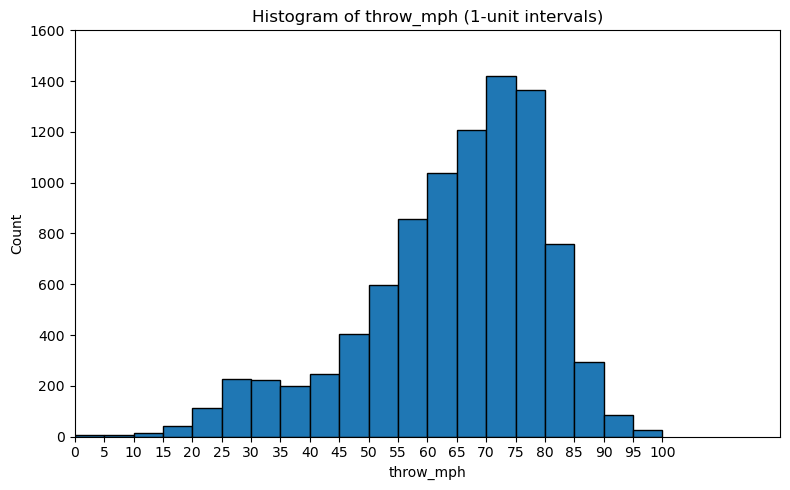

C:\Users\mla21\AppData\Local\Temp\ipykernel_15824\3096225697.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selective_top_mean = every_throw_clean.groupby('thrower_id').apply(selective_top_mean).rename('statcast_mph')
C:\Users\mla21\AppData\Local\Temp\ipykernel_15824\3096225697.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qualified_throw_indices = every_throw_clean.groupby('thrower_id').apply(

,thrower_id,main_pos,max_mph,perc95_mph,count,statcast_mph,mode_trans_ms
0,AKX-1254,center_field,102.651871,94.847793,9,102.651871,1000
1,NYA-2485,center_field,99.723377,93.393901,7,99.723377,1150
2,JZK-1356,right_field,99.008725,97.671335,7,99.008725,1050
3,UKI-2288,shortstop,98.514220,89.877446,11,98.514220,950
4,UPU-2318,left_field,98.438710,96.805590,2,98.438710,1550
5,XAX-2387,left_field,98.327464,96.283135,8,98.327464,1050
6,UPU-1731,right_field,97.736052,94.403791,10,97.736052,850
7,YUH-1918,right_field,96.735421,96.617342,7,96.735421,1100
8,HCI-2523,left_field,95.784446,95.334078,8,95.784446,900
9,VZE-2173,shortstop,95.715063,95.345026,3,95.715063,627


In [10]:
"""
Histogram & Leaderboards
"""
data = every_throw_clean['throw_mph'].dropna()
min_A = np.floor(data.min())
max_A = np.ceil(data.max())
bins = np.arange(min_A, max_A + 1, 5)
plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('throw_mph')
plt.ylabel('Count')
plt.title('Histogram of throw_mph (1-unit intervals)')
plt.xticks(bins)
plt.xlim(0, 120)
plt.ylim(0, 1600)
plt.tight_layout()
plt.show()

def mode_func(x):
    # Return most common value; if tie, returns the first encountered
    return x.mode().iat[0] if not x.mode().empty else None

charting_df = every_throw_clean.groupby('thrower_id').agg(
    main_pos=('player_position', mode_func),
    max_mph=('throw_mph','max'),
    perc95_mph=('throw_mph', lambda x: x.quantile(0.95)),
    count=('throw_mph', 'size')).reset_index() 

def selective_top_mean(group):
    pos = mode_func(group['player_position'])
    x = group['throw_mph']
    n = len(x)
    # Select percentage based on position
    if pos in (3,4,5,6):
        pct = 0.05
    elif pos in (7, 8, 9, 2):
        pct = 0.10
    else:
        pct = 0.01
    k = max(int(np.ceil(pct * n)), 1)
    return x.nlargest(k).mean()
selective_top_mean = every_throw_clean.groupby('thrower_id').apply(selective_top_mean).rename('statcast_mph')
charting_df = charting_df.merge(selective_top_mean, left_on='thrower_id', right_index=True)

def qualified_indices(group):
    pos = mode_func(group['player_position'])
    n = len(group)
    # Select percentage based on position
    if pos in (3,4,5,6):
        pct = 0.05
    elif pos in (7,8,9,2):
        pct = 0.10
    else:
        pct = 0.01
    k = max(int(np.ceil(pct * n)), 1)
    qualified = group.nlargest(k, 'throw_mph')
    return qualified.index  # Return indices of qualified throws
qualified_throw_indices = every_throw_clean.groupby('thrower_id').apply(qualified_indices)
qualified_idx = np.concatenate(qualified_throw_indices.values)
qualified_throws = every_throw_clean.loc[qualified_idx]
# Mode transition (qualified)
qualified_mode_transition = qualified_throws.groupby('thrower_id')['trans_ms'].agg(mode_func).rename('mode_trans_ms')
charting_df = charting_df.merge(qualified_mode_transition, left_on='thrower_id', right_index=True)

# Rename main position
conditions = [
    charting_df['main_pos'] == 1,    charting_df['main_pos'] == 2,    charting_df['main_pos'] == 3,    charting_df['main_pos'] == 4,
    charting_df['main_pos'] == 5,    charting_df['main_pos'] == 6,    charting_df['main_pos'] == 7,    charting_df['main_pos'] == 8,    charting_df['main_pos'] == 9
]
choices = [
    'pitcher','catcher','first_base','second_base','third_base','shortstop',
    'left_field','center_field','right_field'
]
charting_df['main_pos'] = np.select(conditions, choices, default=None)

# Sort
charting_df = charting_df.sort_values(by='statcast_mph', ascending=False).reset_index(drop=True)
HTML(charting_df.head(100)
        .to_html(max_rows=100)
        .replace('<table', '<div style="height:500px;overflow:auto;"><table')
        .replace('</table>', '</table></div>'))